In [3]:
import scanpy as sc
import anndata as ad
import pandas as pd

In [14]:
count_df=pd.read_csv('data/8_antenna.tsv.gz', compression='gzip', sep='\t',header=None, index_col=0)
count_df.index.name=''
count_df=count_df.T

In [15]:
count_df

,128up,14-3-3epsilon,14-3-3zeta,140up,18SrRNA-Psi:CR41602,18w,26-29-p,28SrRNA-Psi:CR40596,28SrRNA-Psi:CR40741,28SrRNA-Psi:CR41609,...,zetaCOP,zf30C,zfh1,zfh2,zip,zld,zormin,zpg,zuc,zyd
1,0,2,3,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,1,3,0,0,3,0,0,0
3,0,2,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,0
5,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5590,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
5591,0,1,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
5592,0,4,7,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0


In [18]:
adata = sc.AnnData(count_df)
adata

/Users/guillaumebelissent/opt/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/guillaumebelissent/opt/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Removing Zeros

In [21]:
pd.Series(count_df.columns.str.startswith('mt')).sum()

40

# Quality Control

None


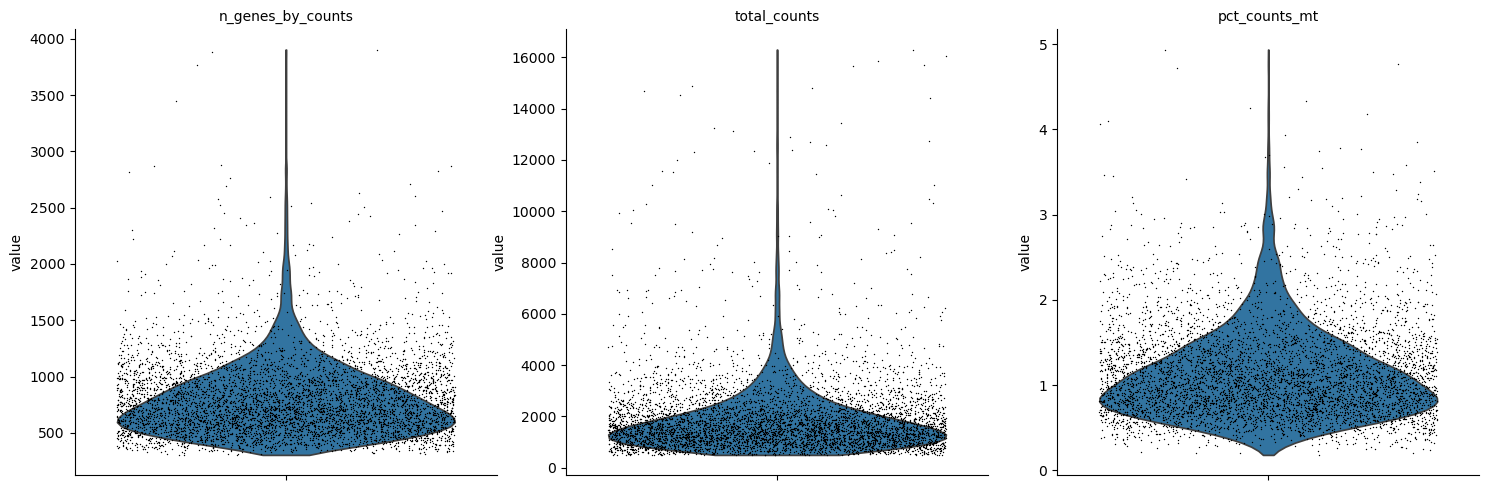

In [23]:
sc.pp.filter_cells(adata, min_genes=1)  # Adjust the threshold as needed
sc.pp.filter_cells(adata, min_counts=1)  # Adjust the threshold as needed

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
print(sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
))
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

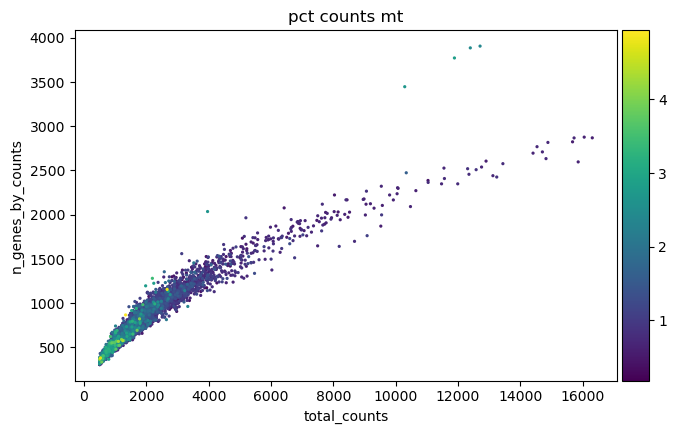

In [24]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Doublet Detection

In [29]:
sc.pp.scrublet(adata)

In [75]:
import numpy as np
print("Min counts:", np.min(adata.X))
print("Max counts:", np.max(adata.X))
print("Mean counts:", np.mean(adata.X))

Min counts: 0
Max counts: 538
Mean counts: 0.15908274066475986


# Normalisation

In [30]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# Feature Selection

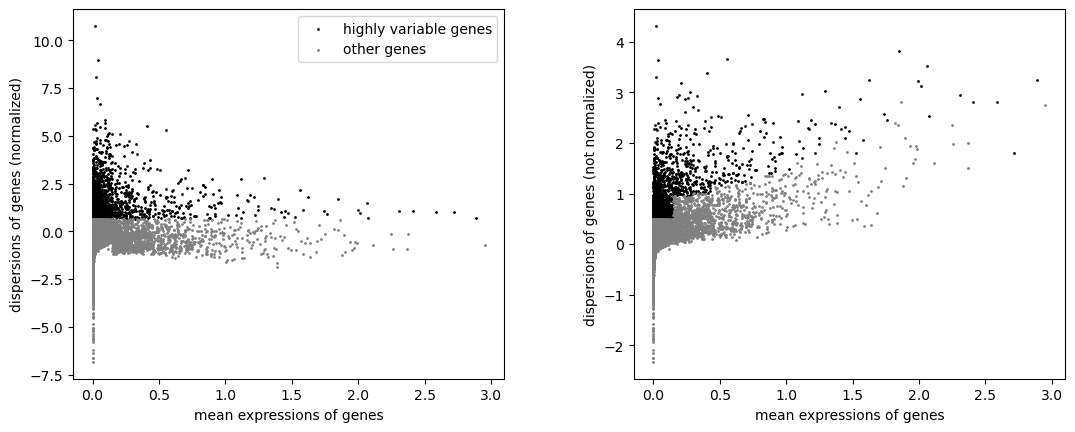

In [32]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

# Dimensionality reduction

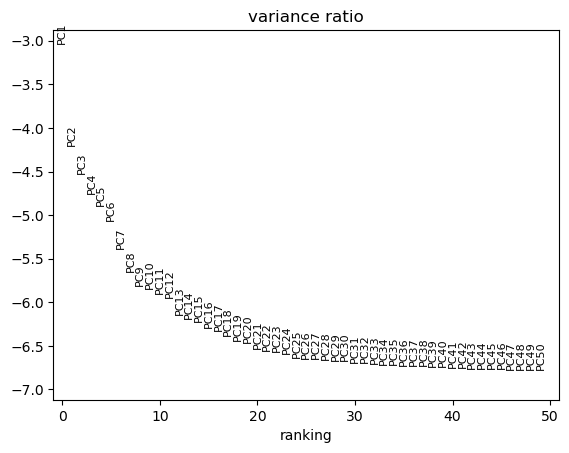

In [35]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

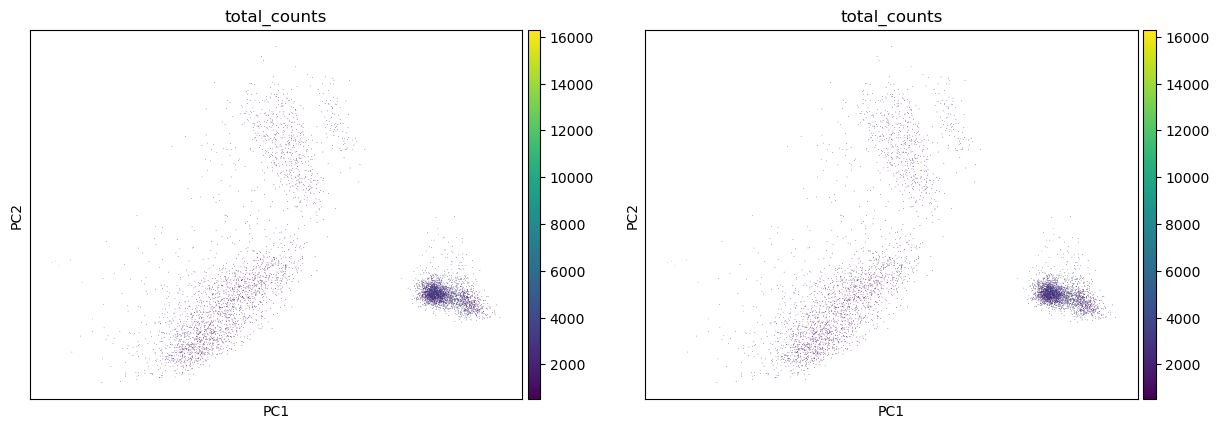

In [41]:
sc.pl.pca(
    adata,
    color=["total_counts", "total_counts"],
    dimensions=[(0, 1), (0, 1)],
    ncols=2,
    size=1,
)

# Nearest Neighbors

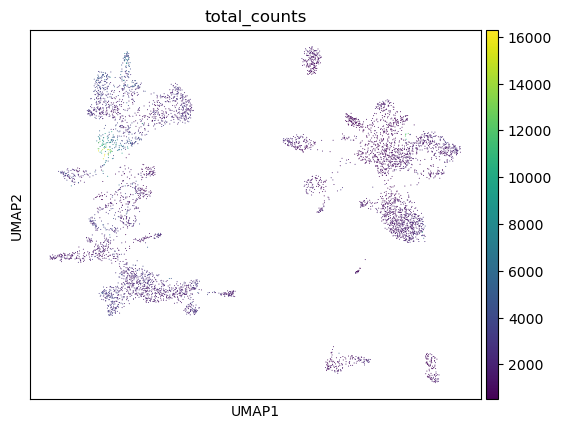

In [43]:
sc.pp.neighbors(adata)

sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="total_counts",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

# Clustering

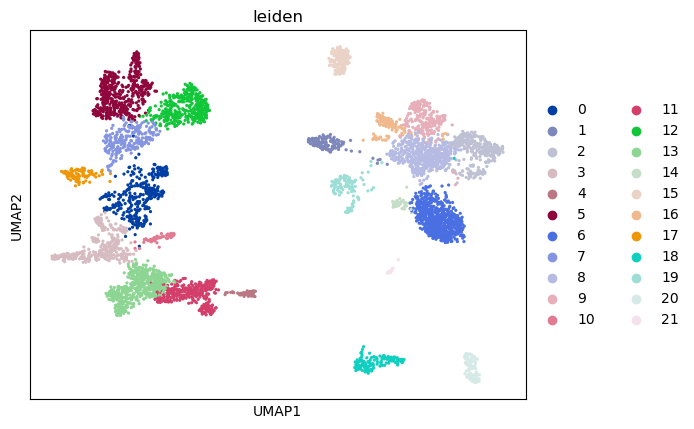

In [44]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
sc.pl.umap(adata, color=["leiden"])

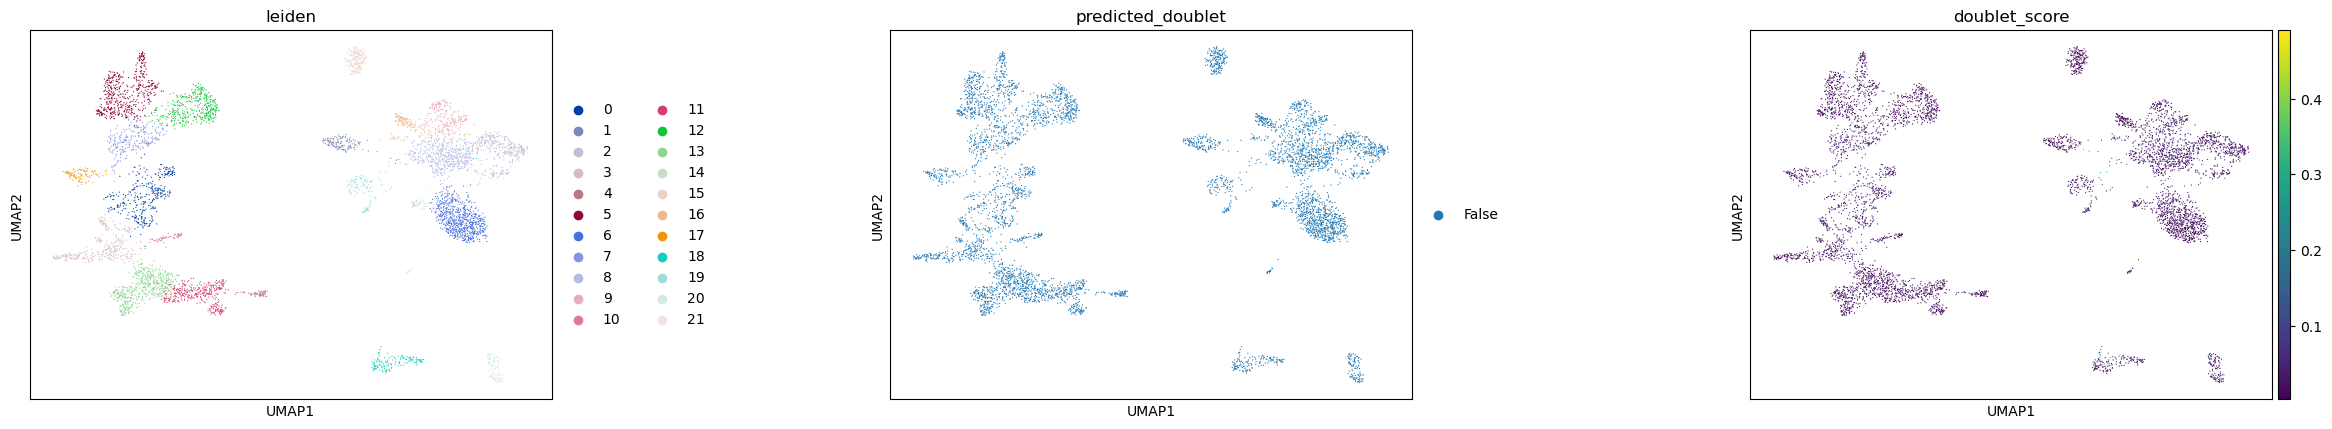

In [45]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

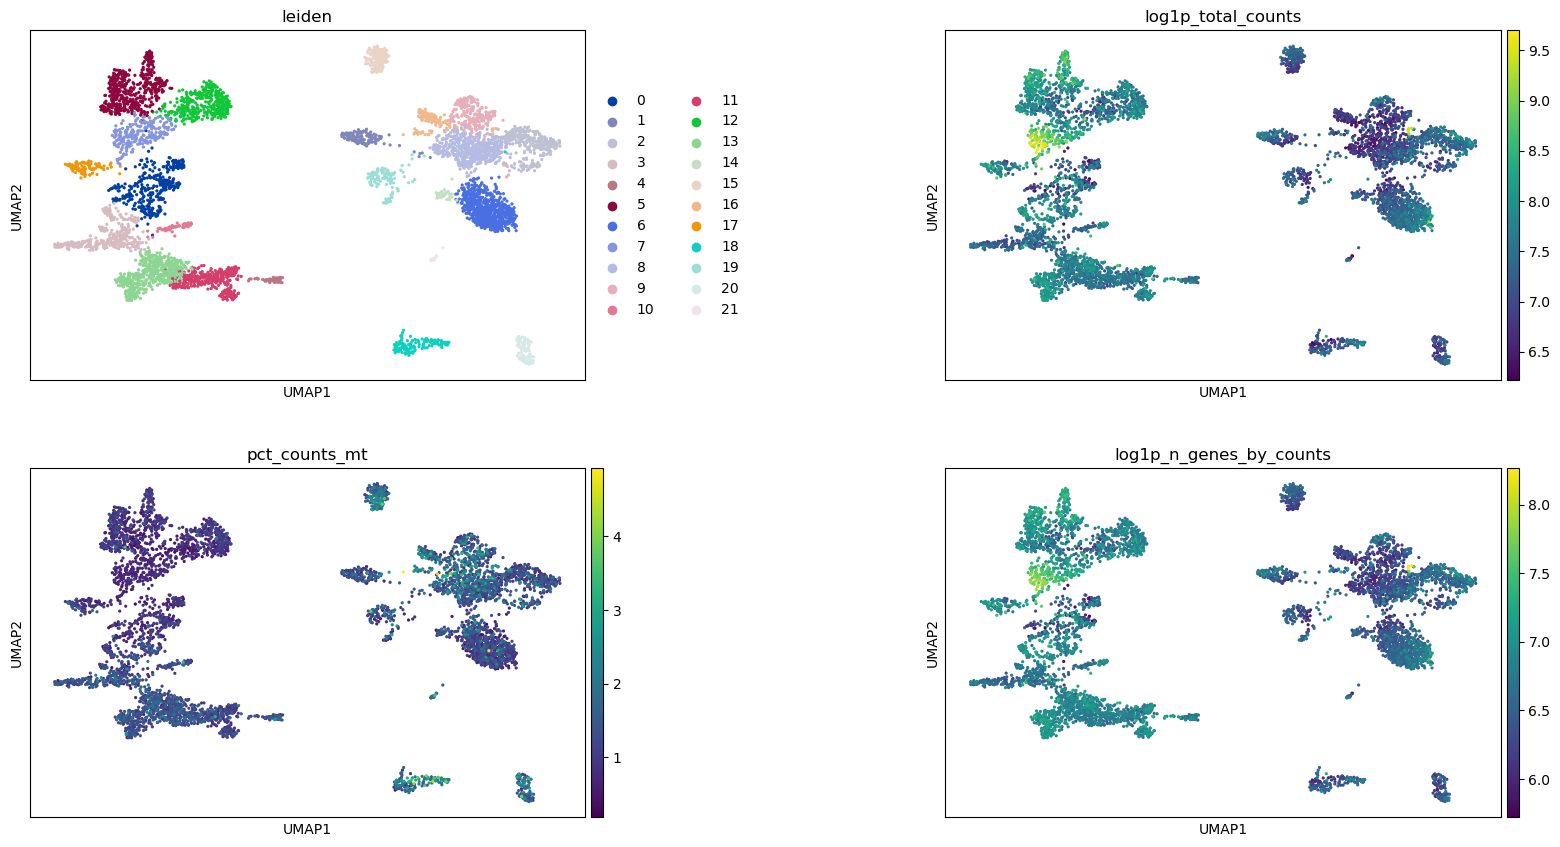

In [46]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [52]:
adata

AnnData object with n_obs × n_vars = 5593 × 11881

In [33]:
# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

# Normalize data
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform the data
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

# Scale the data
sc.pp.scale(adata, max_value=10)

/Users/guillaumebelissent/opt/anaconda3/envs/singlecell/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/guillaumebelissent/opt/anaconda3/envs/singlecell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_61827/2901931940.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


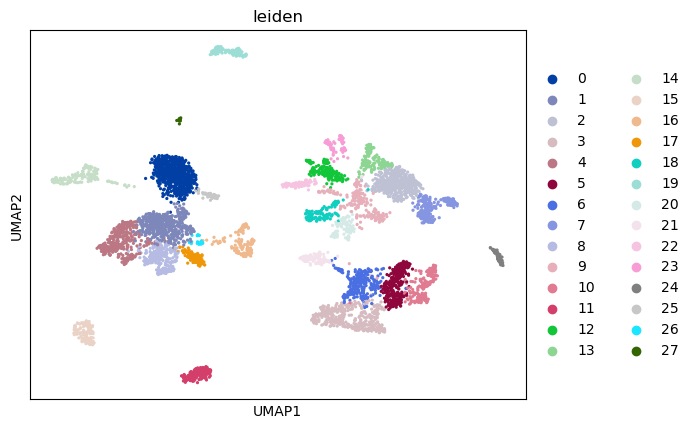

In [54]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# UMAP
sc.tl.umap(adata)

# Clustering
sc.tl.leiden(adata)

# Plot UMAP
sc.pl.umap(adata, color=['leiden'])